<a href="https://colab.research.google.com/github/claredavies/MachineLearningCoursework/blob/main/Assignment1/MLAssignment1KerrasUnbalancedData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Libraries & read in file

In [27]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from google.colab import drive
from sklearn.model_selection import train_test_split
from tensorflow.keras import preprocessing
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.python.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [28]:
from google.colab import files
uploaded = files.upload()
df = pd.read_csv('bank-additional-full.csv', sep=';', delimiter=None, header='infer', names=None, index_col=None)

Saving bank-additional-full.csv to bank-additional-full (3).csv


# Data Exploration

(41188, 21)
No claim 36548
Claim 4640
Claim proportion 11.27%


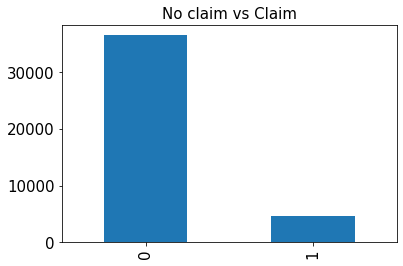

In [29]:
print(df.shape)
df.columns

def percentage(part, whole):
  return 100 * float(part) / float(whole)

df.rename(columns = {'y':'target'}, inplace = True)
df['target'] = df.target.apply(lambda x: 1 if x == "yes" else 0)

no_claim, claim = df.target.value_counts()
print(f'No claim {no_claim}')
print(f'Claim {claim}')
print(f'Claim proportion {round(percentage(claim, claim + no_claim), 2)}%')

df.target.value_counts().plot(kind="bar", title="No claim vs Claim");

## Data preprocessing

Check if any missing features

In [33]:
row_count = df.shape[0]

for c in df.columns:
  m_count = df[df[c] == -1][c].count()
  if m_count > 0:    
    print(f'{c} - {m_count} ({round(percentage(m_count, row_count), 3)}%) rows missing')

Transform numerical data

In [39]:
# use binning 
print(df.pdays.unique())

[999   6   4   3   5   1   0  10   7   8   9  11   2  12  13  14  15  16
  21  17  18  22  25  26  19  27  20]


/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


   age        job  marital  ... euribor3m_log emp.var.rate_log cons.price.idx_log
0   56  housemaid  married  ...      1.580421          0.09531           4.543231
1   57   services  married  ...      1.580421          0.09531           4.543231
2   37   services  married  ...      1.580421          0.09531           4.543231
3   40     admin.  married  ...      1.580421          0.09531           4.543231
4   56   services  married  ...      1.580421          0.09531           4.543231

[5 rows x 20 columns]


target
0    [[AxesSubplot(0.125,0.670278;0.215278x0.209722...
1    [[AxesSubplot(0.125,0.670278;0.215278x0.209722...
dtype: object

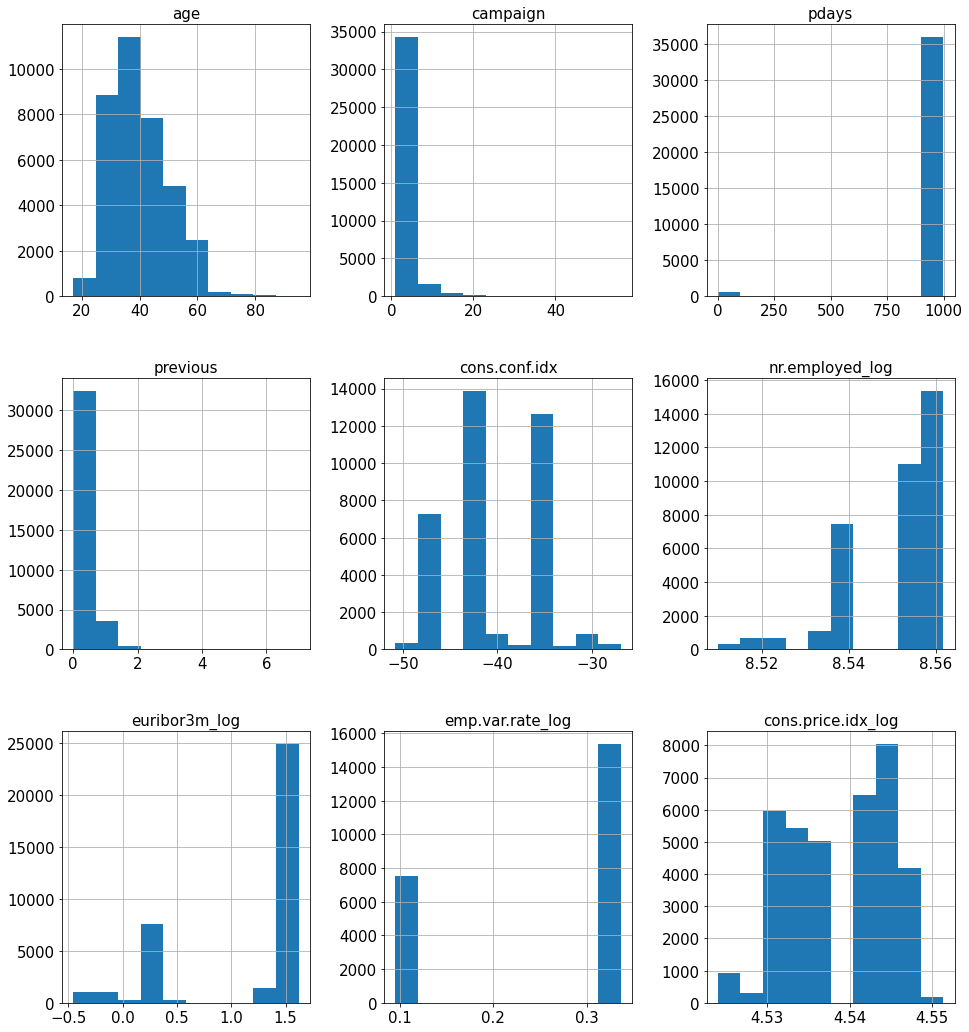

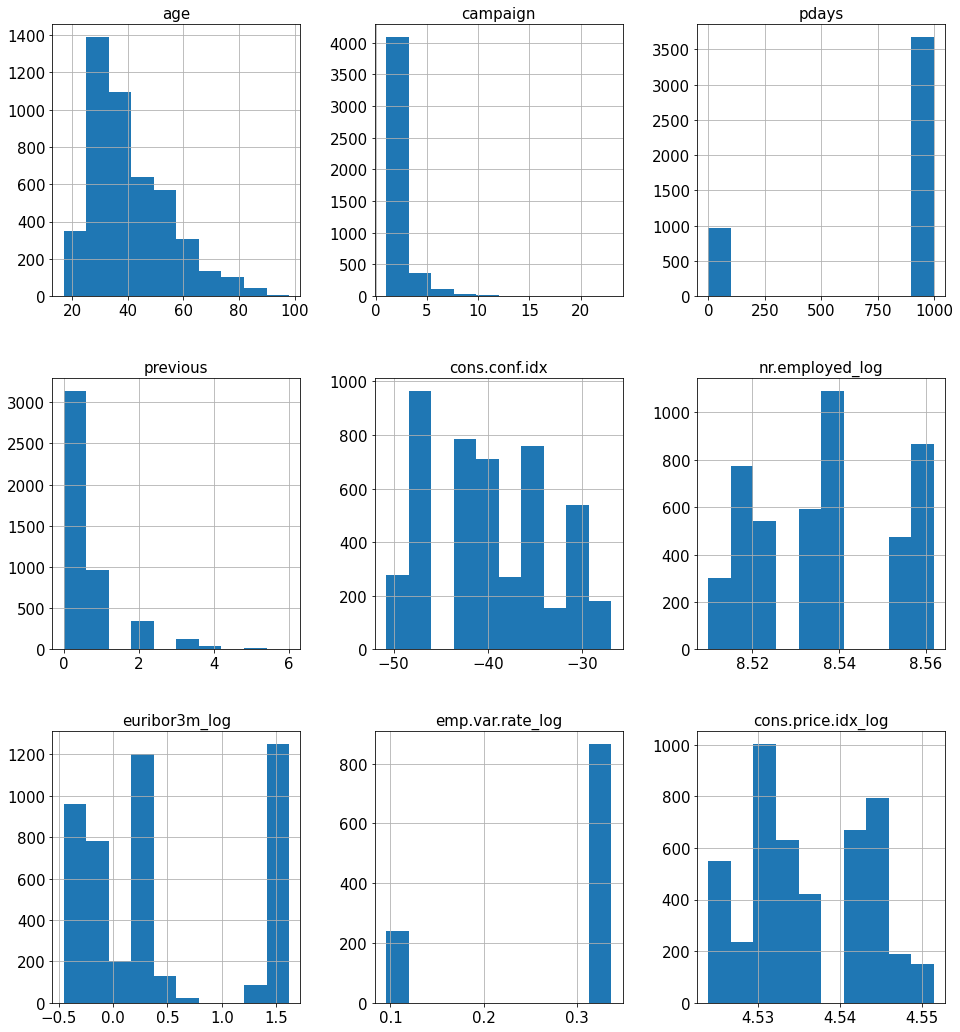

In [57]:
processing_df = df

# Remove - duration as only for benchmark
processing_df = processing_df.drop('duration', 1)
# processing_df['previously_contacted'] = processing_df.pdays.apply(lambda x: 0 if x == 999 else 1)
# processing_df = processing_df.drop('pdays', 1)

# processing_df['pdays_log'] = np.log(processing_df['pdays'])
# processing_df = processing_df.drop('pdays', axis=1)
processing_df['nr.employed_log'] = np.log(processing_df['nr.employed'])
processing_df = processing_df.drop('nr.employed', axis=1)
processing_df['euribor3m_log'] = np.log(processing_df['euribor3m'])
processing_df = processing_df.drop('euribor3m', axis=1)
processing_df['emp.var.rate_log'] = np.log(processing_df['emp.var.rate'])
processing_df = processing_df.drop('emp.var.rate', axis=1)
processing_df['cons.price.idx_log'] = np.log(processing_df['cons.price.idx'])
processing_df = processing_df.drop('cons.price.idx', axis=1)

print(processing_df.head(5))
processing_df.groupby('target').hist(figsize = (16,18))

In [58]:
categorical_columns = ["job","housing", "marital","education","default","loan","contact","month","day_of_week","poutcome"]

# Using one-hot encoding as no order so don't confuse model
for column in categorical_columns:
    tempdf = pd.get_dummies(processing_df[column], prefix=column)
    processing_df = pd.merge(
        left=processing_df,
        right=tempdf,
        left_index=True,
        right_index=True,
    )
    processing_df = processing_df.drop(columns=column)

# print(processing_df.info())
# processing_df.groupby('target').hist(figsize = (16,18))

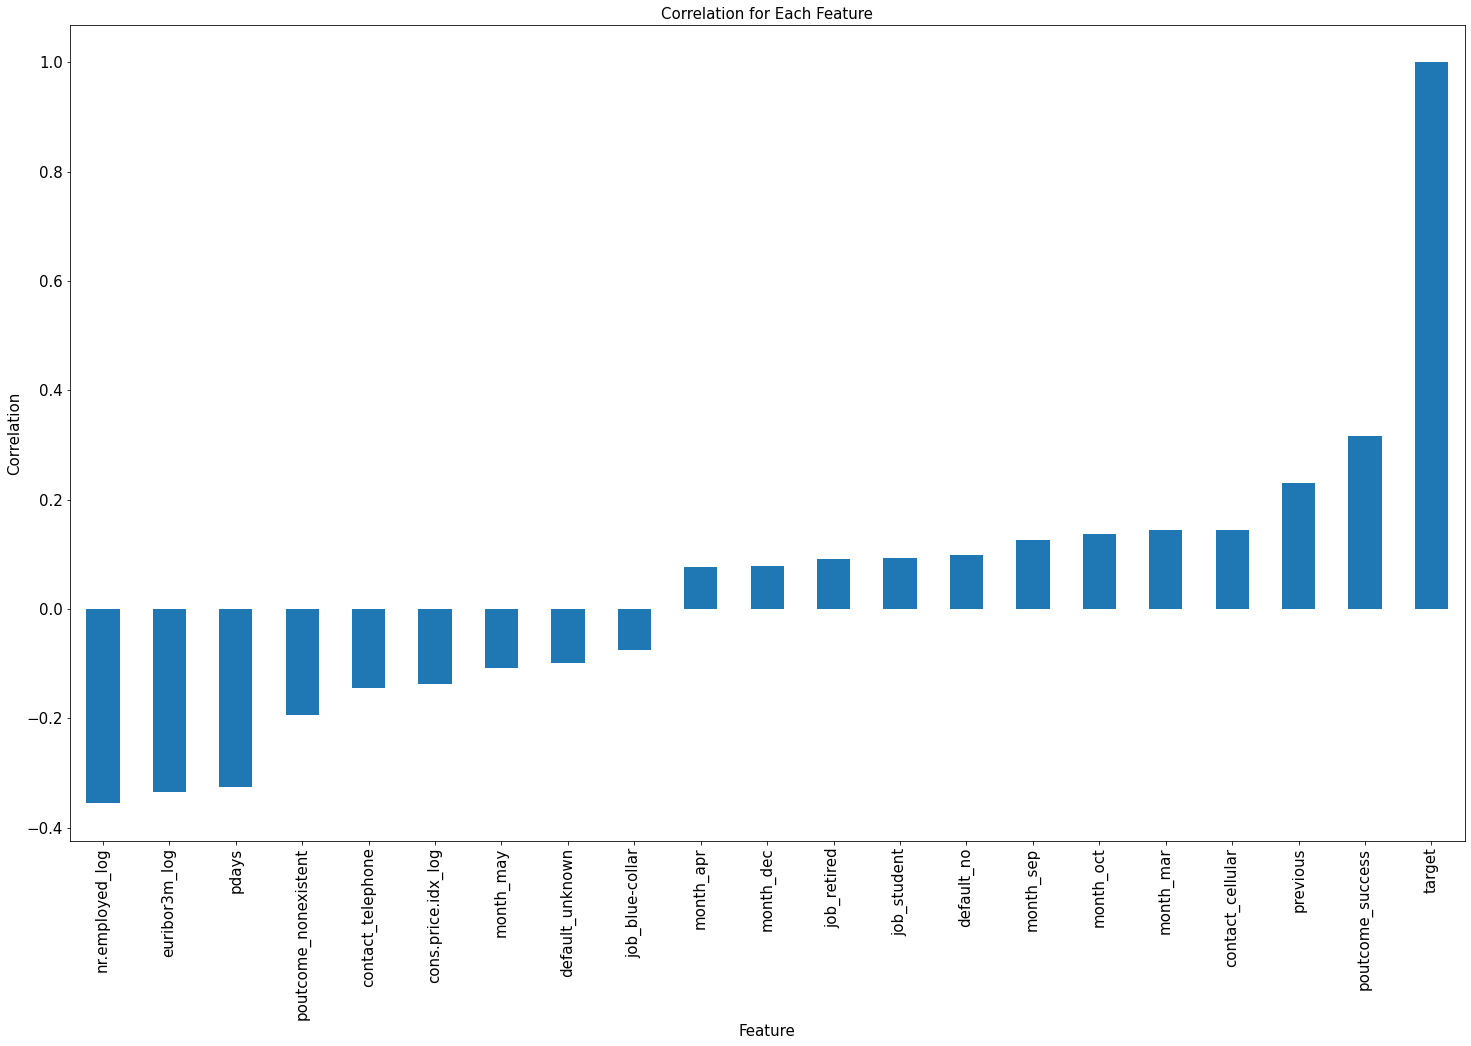

In [59]:
# # Create correlation matrix
std_features_keep = processing_df
corr_matrix = std_features_keep.corr()['target'].sort_values()
threshold = 0.07

for  i, v in corr_matrix.iteritems():
    if(abs(v) < threshold):
      std_features_keep = std_features_keep.drop(i, axis=1)

# Plot for correlation
SMALL_SIZE = 15
plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=SMALL_SIZE)
std_plot = (std_features_keep.corr()['target'].sort_values()).plot(kind="bar",figsize=(25,15))
plt.xlabel('Feature')
plt.ylabel('Correlation')
plt.title('Correlation for Each Feature')
plt.show()

# Metrics

In [60]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [166]:
from sklearn.metrics import confusion_matrix

def get_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  print('% right for no: ', (cm[0][0]/(cm[0][0] + cm[0][1]))*100)
  print('% right for yes: ', (cm[1][1]/(cm[1][1] + cm[1][0]))*100)
  return cm

def plot_cm(labels, predictions, p=0.5):
  tick_labels = ['Y', 'N']
  cm = get_cm(labels, predictions, p)
  ax = sns.heatmap(cm, annot=True, fmt="d")
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  ax.set_xticklabels(tick_labels)
  ax.set_yticklabels(tick_labels)

In [62]:
from sklearn.metrics import f1_score

def print_metrics(model, evaluation_results, predictions):
  for name, value in zip(model.metrics_names, evaluation_results):
    print(name, ': ', value)
  print(f'f1 score: {f1_score(y_test, np.round(y_pred.flatten()))}')
  print()

In [ ]:
def visualise_training_history_loss(history,title):
  # Get training and test accuracy histories
  training_accuracy = history.history["acc"]
  test_accuracy = history.history["val_acc"]
  plt.plot(epoch_count, training_accuracy, "r--")
  plt.plot(epoch_count, test_accuracy, "b-")
  # Visualize accuracy history
  plt.legend(["Training Accuracy", "Test Accuracy"])
  plt.title(title)
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy Score")
  plt.show()

In [161]:
def visualise_training_history_loss(history,title):
  # Get training and test loss histories
  training_loss = history.history["loss"]
  test_loss = history.history["val_loss"]
  # Create count of the number of epochs
  epoch_count = range(1, len(training_loss) + 1)

  # Visualize loss history
  plt.plot(epoch_count, training_loss, "r--")
  plt.plot(epoch_count, test_loss, "b-")
  plt.legend(["Training Loss", "Test Loss"])
  plt.title(title)
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.show()

## Neural Network

In [179]:
BATCH_SIZE = 2048


import keras
from keras import backend as K
import tensorflow as tf
from keras import layers

# 0.01, 0.001, or 0.0001
learning_rate_intial = 0.095

def build_model(train_data,learning_rate,output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  network = keras.Sequential()
  # Add a dropout layer for input layer
  network.add(layers.Dropout(0.5, input_shape=(train_data.shape[-1],)))
  # Add fully connected layer with a ReLU activation function
  network.add(layers.Dense(units=16, activation="relu"))
  # Add a dropout layer for previous hidden layer
  network.add(layers.Dropout(0.5))
  # Add fully connected layer with a ReLU activation function
  network.add(layers.Dense(units=16, activation="relu"))
  # Add a dropout layer for previous hidden layer
  network.add(layers.Dropout(0.5))
  # Add fully connected layer with a sigmoid activation function
  network.add(layers.Dense(units=1, activation="sigmoid",bias_initializer=output_bias))

  network.compile(
    optimizer="rmsprop",
    loss=keras.losses.BinaryCrossentropy(),
    metrics=METRICS
  )

  return network

# Split Training and Test Data

In [180]:
from sklearn.model_selection import train_test_split

X = std_features_keep.drop("target", axis=1)
print(X.head(5))
y = df['target']

labels = X.columns.values

from sklearn.preprocessing import StandardScaler
standardizer = StandardScaler()
X = standardizer.fit_transform(X)

# Print mean and standard deviation
print("Mean:", round(X[:,0].mean()))
print("Standard deviation:", X[:,0].std())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=RANDOM_SEED)

   pdays  previous  ...  poutcome_nonexistent  poutcome_success
0    999         0  ...                     1                 0
1    999         0  ...                     1                 0
2    999         0  ...                     1                 0
3    999         0  ...                     1                 0
4    999         0  ...                     1                 0

[5 rows x 20 columns]
Mean: 0
Standard deviation: 0.9999999999999999


# Plain Model

In [194]:
plain_model = build_model(X_train, learning_rate_intial)

# Set callback functions to early stop training and save the best model so far
callbacks = [EarlyStopping(monitor="val_loss", patience=2),
ModelCheckpoint(filepath="best_model.h5", monitor="val_loss", save_best_only=True)]

history_plain = plain_model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=100,
    validation_data=(X_test, y_test), 
    callbacks=callbacks,
    shuffle=True)



Epoch 1/100
20/20 [==============================] - 6s 124ms/step - loss: 0.6262 - tp: 961.0000 - fp: 6103.0000 - tn: 30445.0000 - fn: 3679.0000 - accuracy: 0.7625 - precision: 0.1360 - recall: 0.2071 - auc: 0.4964 - prc: 0.1407 - val_loss: 0.4457 - val_tp: 4.0000 - val_fp: 5.0000 - val_tn: 1818.0000 - val_fn: 233.0000 - val_accuracy: 0.8845 - val_precision: 0.4444 - val_recall: 0.0169 - val_auc: 0.5198 - val_prc: 0.1492
Epoch 2/100
20/20 [==============================] - 0s 10ms/step - loss: 0.5342 - tp: 587.0000 - fp: 2994.0000 - tn: 31731.0000 - fn: 3816.0000 - accuracy: 0.8260 - precision: 0.1639 - recall: 0.1333 - auc: 0.5062 - prc: 0.1404 - val_loss: 0.3965 - val_tp: 3.0000 - val_fp: 4.0000 - val_tn: 1819.0000 - val_fn: 234.0000 - val_accuracy: 0.8845 - val_precision: 0.4286 - val_recall: 0.0127 - val_auc: 0.6290 - val_prc: 0.2355
Epoch 3/100
20/20 [==============================] - 0s 9ms/step - loss: 0.4809 - tp: 505.0000 - fp: 1711.0000 - tn: 33014.0000 - fn: 3898.0000 - acc

loss :  0.3002917766571045
tp :  0.0
fp :  0.0
tn :  1823.0
fn :  237.0
accuracy :  0.8849514722824097
precision :  0.0
recall :  0.0
auc :  0.7831390500068665
prc :  0.4098972678184509
f1 score: 0.0

% right for no:  100.0
% right for yes:  0.0


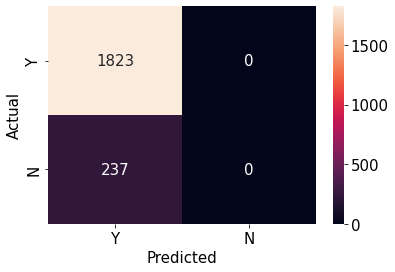

In [195]:
evaluation_results = plain_model.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=0)
y_pred = plain_model.predict(X_test, batch_size=BATCH_SIZE)
print_metrics(plain_model, evaluation_results, y_pred)
plot_cm(y_test, y_pred)

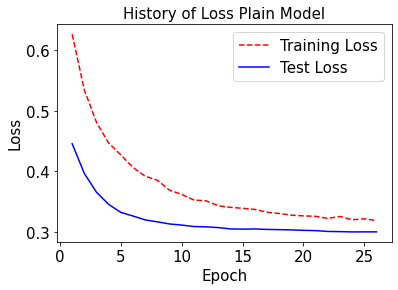

In [196]:
visualise_training_history(history_plain,"History of Loss Plain Model")

# Weighted model

In [198]:
no_claim_count, claim_count = np.bincount(df.target)
total_count = len(df.target)

weight_no_claim = ((1 / no_claim_count) * (total_count) / 2.0 )
weight_claim = (((1 / claim_count) * (total_count) / 2.0 )) 
print("no claim:  " + str(weight_no_claim))
print("claim:  " + str(weight_claim))
class_weights = {0: weight_no_claim, 1: weight_claim}

no claim:  0.5634781656999015
claim:  4.438362068965517


In [215]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

initial_bias = np.log([claim/no_claim])
model_weighted = build_model(X_train, learning_rate_intial, initial_bias)

callbacks = [EarlyStopping(monitor="val_loss", patience=4),
ModelCheckpoint(filepath="best_model.h5", monitor="val_loss", save_best_only=True)]
history_weighted = model_weighted.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=100,
    validation_data=(X_test, y_test), 
    callbacks=callbacks,
    shuffle=True,
    class_weight=class_weights
)

Epoch 1/100
20/20 [==============================] - 5s 63ms/step - loss: 0.9332 - tp: 1960.0000 - fp: 8550.0000 - tn: 27998.0000 - fn: 2680.0000 - accuracy: 0.7273 - precision: 0.1865 - recall: 0.4224 - auc: 0.6133 - prc: 0.2049 - val_loss: 0.3699 - val_tp: 83.0000 - val_fp: 93.0000 - val_tn: 1730.0000 - val_fn: 154.0000 - val_accuracy: 0.8801 - val_precision: 0.4716 - val_recall: 0.3502 - val_auc: 0.7642 - val_prc: 0.3434
Epoch 2/100
20/20 [==============================] - 0s 8ms/step - loss: 0.8552 - tp: 1791.0000 - fp: 7215.0000 - tn: 27510.0000 - fn: 2612.0000 - accuracy: 0.7488 - precision: 0.1989 - recall: 0.4068 - auc: 0.6244 - prc: 0.2183 - val_loss: 0.3615 - val_tp: 80.0000 - val_fp: 91.0000 - val_tn: 1732.0000 - val_fn: 157.0000 - val_accuracy: 0.8796 - val_precision: 0.4678 - val_recall: 0.3376 - val_auc: 0.7741 - val_prc: 0.3565
Epoch 3/100
20/20 [==============================] - 0s 10ms/step - loss: 0.8296 - tp: 1765.0000 - fp: 6776.0000 - tn: 27949.0000 - fn: 2638.0000

Evaluation

loss :  0.36687329411506653
tp :  72.0
fp :  78.0
tn :  1745.0
fn :  165.0
accuracy :  0.8820388317108154
precision :  0.47999998927116394
recall :  0.3037974536418915
auc :  0.7772057056427002
prc :  0.388385534286499
f1 score: 0.37209302325581395

% right for no:  95.72133845309929
% right for yes:  30.37974683544304


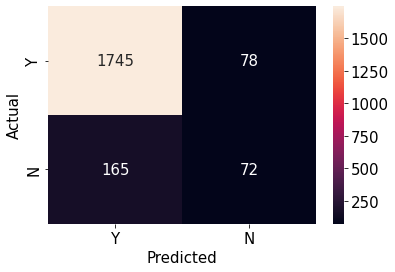

In [216]:
evaluation_results = model_weighted.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=0)
y_pred = model_weighted.predict(X_test, batch_size=BATCH_SIZE)
print_metrics(model_weighted, evaluation_results, y_pred)
plot_cm(y_test, y_pred)

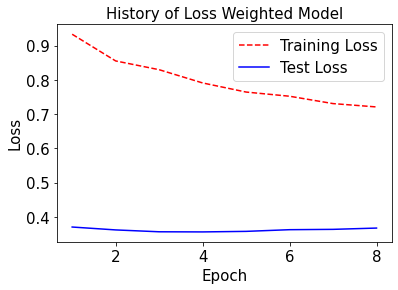

In [217]:
visualise_training_history(history_weighted,"History of Loss Weighted Model")

# Resampling

In [202]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=RANDOM_SEED, sampling_strategy=1.0);
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

No claim Resampled 34725
Claim Resampled 34725
Claim Resampled proportion 50.0%


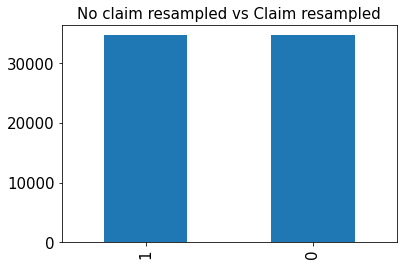

In [203]:
def percentage(part, whole):
  return 100 * float(part) / float(whole)

no_claim_resampled, claim_resampled = y_train_resampled.value_counts()
print(f'No claim Resampled {no_claim_resampled}')
print(f'Claim Resampled {claim_resampled}')
print(f'Claim Resampled proportion {round(percentage(claim_resampled, claim_resampled + no_claim_resampled), 2)}%')

y_train_resampled.value_counts().plot(kind="bar", title="No claim resampled vs Claim resampled");

In [220]:
model_resampled = build_model(X_train_resampled, learning_rate_intial)

# Set callback functions to early stop training and save the best model so far
callbacks = [EarlyStopping(monitor="val_loss", patience=4),
ModelCheckpoint(filepath="best_model.h5", monitor="val_loss", save_best_only=True)]
history_resampled = model_resampled.fit(
    X_train_resampled,
    y_train_resampled,
    batch_size=BATCH_SIZE,
    epochs=100,
    validation_data=(X_test, y_test), 
    callbacks=callbacks,
    shuffle=True,
)

Epoch 1/100
34/34 [==============================] - 4s 42ms/step - loss: 1.0285 - tp: 23953.0000 - fp: 25773.0000 - tn: 10775.0000 - fn: 11009.0000 - accuracy: 0.4856 - precision: 0.4817 - recall: 0.6851 - auc: 0.5045 - prc: 0.5311 - val_loss: 0.9299 - val_tp: 235.0000 - val_fp: 1741.0000 - val_tn: 82.0000 - val_fn: 2.0000 - val_accuracy: 0.1539 - val_precision: 0.1189 - val_recall: 0.9916 - val_auc: 0.7142 - val_prc: 0.2968
Epoch 2/100
34/34 [==============================] - 0s 7ms/step - loss: 0.8433 - tp: 26471.0000 - fp: 25225.0000 - tn: 9500.0000 - fn: 8254.0000 - accuracy: 0.5179 - precision: 0.5121 - recall: 0.7623 - auc: 0.5599 - prc: 0.5864 - val_loss: 0.8391 - val_tp: 215.0000 - val_fp: 1309.0000 - val_tn: 514.0000 - val_fn: 22.0000 - val_accuracy: 0.3539 - val_precision: 0.1411 - val_recall: 0.9072 - val_auc: 0.7576 - val_prc: 0.3564
Epoch 3/100
34/34 [==============================] - 0s 7ms/step - loss: 0.7636 - tp: 27159.0000 - fp: 24076.0000 - tn: 10649.0000 - fn: 7566

loss :  0.5479848384857178
tp :  161.0
fp :  371.0
tn :  1452.0
fn :  76.0
accuracy :  0.7830097079277039
precision :  0.30263158679008484
recall :  0.6793248653411865
auc :  0.7853134870529175
prc :  0.4304620027542114
f1 score: 0.4187256176853056

% right for no:  79.64893033461328
% right for yes:  67.9324894514768


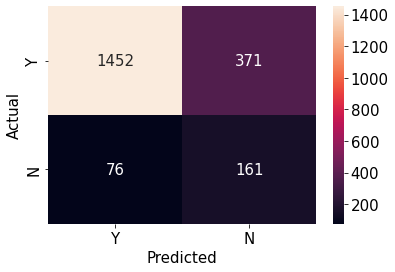

In [221]:
evaluation_results = model_resampled.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=0)
y_pred = model_resampled.predict(X_test, batch_size=BATCH_SIZE)
print_metrics(model_resampled, evaluation_results, y_pred)
plot_cm(y_test, y_pred)

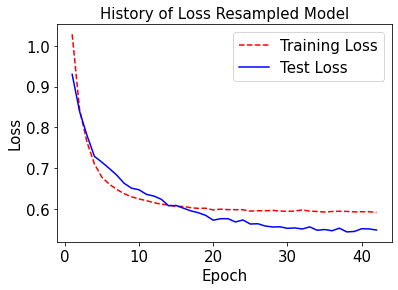

In [222]:
visualise_training_history(history_resampled,"History of Loss Resampled Model")

# Architecture

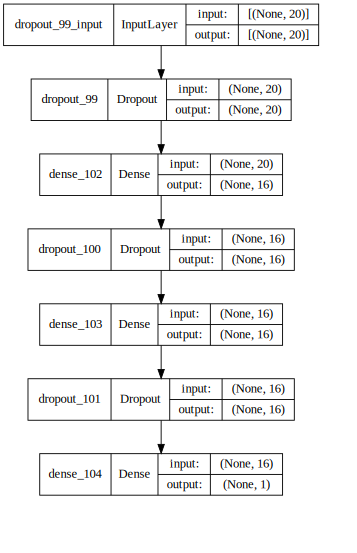

In [178]:
from IPython.display import SVG
import tensorflow as tf
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model_weighted, show_shapes= True, show_layer_names=True, dpi=65).create(prog='dot', format='svg'))